# Implmentation of LE-NET 5 model using PyTorch and quantize the model. 

## Problem Formulation:
We want to create a pre-defined deep learning model **(LE-NET 5)** to do multi-calssification task of numerical digits (0-9) based on the image of this digits **(all digits in the images are hand-written)**.

## Dataset
our data is **Reduced minist dataset**, it's already divided into two folders one represent the **training dataset** and the another represent the **testing dataset**, each of these folders divided into *10* arranged folders (0-9), each folder in either **training dataset** folder or **testing dataset** folder has images of one digit and each of these folders has equal number of images to the other folders.
</br></br>




**training dataset**: has **1000** samples in each digit folder (Total: **10000** samples).

**testing dataset**: has **200** samples in each digit folder (Total: **2000** samples).


## Experimental Protocol.

1. Import all required packages.
2. read each from each folder and get their data as numpy array.
3. pre-processing the images.
  1. Normalizing the images values by dividing each value by *255*, and change the their type to **float16**.
  2. change their sizes from 28\*28 to 32\*32 by add padding of zeros to each image.
  3. append each array of images with its true value and collect all of these data in one dictionary.
</br>


4. convert the dictionary of data to dataframe and shuffle all the data.
5. divide **training set* to *75%* of its size as **training set* and *25%* of its size as **validation set** to use **validation set** in the training process to prevent the overfitting.
6. divide *(X_train, y_train, X_val, y_val, X_test, y_test)* into batchs.
7. convert each batch into tesnor and reshape each data in **6** to this formula *(number_of_batchs, batch_size, 1, image_x, image_y)*.
8. Build **the Le-net 5** model.
9. Build helper functions *(train, valid, plotting, accuracy)*.
10. compile the model (create the **adam optimizer** with proper **learning rate** and the **loss function**).
11. train the model and calculate the training loss and validation loss.
11. test the model and calculate the test loss and test accuracy using **evaluate_model()** function.
12. quantize **the Le-net 5** model.
13. compare the size of the weights of **the Le-net 5** and **the quantized Le-net 5** model.
13. test **the quantized Le-net 5** model and **the Le-net 5** model.


### 1. Import all required packages.


In [2]:
import torch
import torchvision
import torchvision.transforms as tr
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import copy
from PIL import Image
from torch import nn
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datetime import datetime 
from torchvision import datasets, transforms
import math
import random
import time

In [3]:
#64 Batch size
BATCH_SIZE = 63

In [4]:
def shuffle_split_data(X_dataset, y_dataset, train_size):
    """
    This function is responsible for divding the dataset to X_train, y_train, X_val, y_val.

    param:
    X_dataset: training data input as Series or numpy array.
    y_dataset: training data output as Series or numpy array.
    train_size: the present of the X_train and y_train data.
    """
    X_dataset = np.array(X_dataset)
    y_dataset = np.array(y_dataset)
    arr_rand = np.random.rand(X_dataset.shape[0])
    split = arr_rand < np.percentile(arr_rand, train_size)

    X_train = X_dataset[split]
    y_train = y_dataset[split]
    X_val =  X_dataset[~split]
    y_val = y_dataset[~split]

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [5]:
training_img_folder = "/content/drive/MyDrive/Colab Notebooks/Datasets/ReducedMNISTData/ReducedTraingingdata"
testing_img_folder = "/content/drive/MyDrive/Colab Notebooks/Datasets/ReducedMNISTData/Reduced Testing data"

def create_dataset(images_folder):
    """
    This function is responsible for create a dataframe of two columns (image_data as numpy array, image_value as integer value)

    param:
    images_folder: path of the whole dataset with 10 folders.
    """
    dataset = {}
    images = []
    images_values = []
    for path, subdirs, files in os.walk(images_folder):
        for name in files:
          if name.endswith('jpg'):
            #read image as numpy array and normalize its values.
            image = np.asarray(Image.open(f'{path}/{name}')) / 255.0
            #convert their values to float16. 
            image = image.astype('float16')
            #convert them to 32*32 by adding border of zeros around each image. 
            image = np.pad(image, ((2,2),(2,2)), 'constant')
            #add third dim as 1.
            image = image.reshape(1,32,32)
            #append image data to list of images data.
            images.append(image)
            #append name of the folder (digit) as the true value of that image.
            images_values.append(int(path[-1]))
            
    dataset['images'] = images
    dataset['images_values'] = images_values
    return dataset

#create training dataset as dictionary and the keys are the column names.
training_dataset = create_dataset(training_img_folder)
#create testing dataset as dictionary and the keys are the column names.
testing_dataset = create_dataset(testing_img_folder)

#convert training dataset, testing dataset dictionary to dataframe.
training_dataset, testing_dataset  = pd.DataFrame(training_dataset), pd.DataFrame(testing_dataset)
#shuffle the data inside training_dataset and testing_dataset.
training_dataset, testing_dataset = training_dataset.sample(frac=1).reset_index(drop=True), testing_dataset.sample(frac=1).reset_index(drop=True)

In [6]:
#divide training_dataset to X_train, y_train, X_val, y_val where training dataset is 75% of the original training dataset.
X_train, y_train, X_val, y_val = shuffle_split_data(training_dataset['images'], training_dataset['images_values'], train_size = 75)

In [7]:
#print samples in each dataset.
num_of_training_samples = len(X_train)
num_of_validation_samples = len(X_val)
num_of_testing_samples = len(testing_dataset)
print(f"num_of_training_samples: {len(X_train)}")
print(f"num_of_validation_samples: {len(X_val)}")
print(f"num_of_testing_samples: {len(testing_dataset)}")

num_of_training_samples: 7500
num_of_validation_samples: 2500
num_of_testing_samples: 2000


In [8]:
#divid each dataset into batches.
X_train = np.array_split(X_train,len(X_train) / BATCH_SIZE )
y_train = np.array_split(y_train, len(y_train) / BATCH_SIZE)
X_val = np.array_split(X_val, len(X_val) / BATCH_SIZE )
y_val = np.array_split(y_val, len(y_val) / BATCH_SIZE )
X_test = np.array_split(np.array(training_dataset['images']), len(training_dataset['images']) / 20 )
y_test = np.array_split(np.array(training_dataset['images_values']), len(training_dataset['images_values']) / 20 )

### Convert data to pytorch tensors.

In [9]:
def convert_input_to_torch_tensor(data):
  """
  function to convert every batch in the dataset to pytorch tensor and reshape this batch to (batch_size, 1, 32, 32)
  """
  images = []
  for i in range(len(data)):
    #create empty array
    arr = np.empty(shape=[1, 32, 32])
    for j in range(len(data[i])):
      #stack all the images in the batch together.
      arr = np.vstack((arr, data[i][j]))
    #delete first image or the empty image
    arr = np.delete(arr, (0), axis=0)
    #reshape each batch in the dataset
    arr = arr.reshape((arr.shape[0],1,32,32))
    #convert it into tensor
    arr = torch.from_numpy(arr)
    #append this batch to the new dataset.
    images.append(arr)
  data = np.array(images, dtype = object)
  return data

In [10]:
def convert_output_to_torch_tensor(data):
  """
  convert every output dataset to pytorch tensor.
  """
  for i in range(len(data)):
    data[i] = torch.from_numpy(data[i])
  return data

In [11]:
X_train = convert_input_to_torch_tensor(X_train)
X_val = convert_input_to_torch_tensor(X_val)
X_test = convert_input_to_torch_tensor(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


In [12]:
y_train = convert_output_to_torch_tensor(y_train)
y_val = convert_output_to_torch_tensor(y_val)
y_test = convert_output_to_torch_tensor(y_test)

In [13]:
print(type(X_train[0]))
print(type(y_test[0]))
print(X_train[0].shape)
print(y_test[0].shape)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([64, 1, 32, 32])
torch.Size([20])


### Create Le-Net 5 Model and all helper functions then train this model.

**The LeNet 5 model** takes input of size **32x32x1** and emits a **10-dimentional output**, since the model is trained to recognize **handwritten digits (0-9)**.

In [14]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        #feature extraction layers
        self.CNN = nn.Sequential(
        nn.Conv2d(1, 28, kernel_size=(5,5), stride = (1,1), padding = (0, 0)),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(28, 16, kernel_size=(5,5), stride = (1,1), padding = (0, 0)),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2))

        #flat the output of AvgPool2d layer.
        self.flat=nn.Flatten()
        
        #Fully connected layers to update the weights.
        self.FC = nn.Sequential(
            nn.Linear(400,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10))
        
    def forward(self,x):

        output = self.CNN(x)
        output = self.flat(output)
        logits = self.FC(output)
        return logits

In [15]:
def train(X_train, y_train, model, criterion, optimizer, device):
    '''
    Function for the training process of the training loop
    '''
    model.train()
    running_loss = 0

    for x, y_true in zip(X_train, y_train):
        optimizer.zero_grad()
            
        # Forward pass
        x=x.float()
        y_true = y_true.type(torch.LongTensor)
        x = x.to(device)
        y_true = y_true.to(device)

        predicted_y = model(x)
        loss = criterion(predicted_y, y_true) 
        running_loss += loss.item() * x.size(0)

        # Backward pass
        loss.backward()
        #Optimize the weights using backpropagation.
        optimizer.step()
    epoch_loss = running_loss / num_of_training_samples
    return model, optimizer, epoch_loss

In [16]:
def validate(X_val, y_val, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    for x, y_true in zip(X_val, y_val):
        # Forward pass and record loss
        x=x.float()
        y_true = y_true.type(torch.LongTensor)
        x = x.to(device)
        y_true = y_true.to(device)

        predicted_y = model(x)
        #Calculate the loss
        loss = criterion(predicted_y, y_true)
        running_loss += loss.item() * x.size(0)

    epoch_loss = running_loss / num_of_validation_samples
        
    return model, epoch_loss

In [17]:
def accuracy(model, input, output , device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for x, y_true in zip(input, output):
            x=x.float()
            y_true = y_true.type(torch.LongTensor)

            x = x.to(device)
            y_true = y_true.to(device)

            predicted_y = model(x)
            predicted_labels = torch.max(predicted_y, 1)
            n += y_true.size(0)
            correct_pred += (predicted_labels[1] == y_true).sum()
    return correct_pred.float() / n * 100

In [18]:
def model_evaluation(model, input, output, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        #load weights of the model.
        model.eval()
        running_loss = 0
        for x, y_true in zip(input, output):
            x=x.float()
            y_true = y_true.type(torch.LongTensor)
            x = x.to(device)
            y_true = y_true.to(device)
            predicted_y = model(x)
            loss = criterion(predicted_y, y_true)
            predicted_labels = torch.max(predicted_y, 1)
            n += y_true.size(0)
            correct_pred += (predicted_labels[1] == y_true).sum()
            running_loss += loss.item() * x.size(0)
            acc = correct_pred.float() / n * 100
    return round((running_loss / num_of_validation_samples),3), round(acc.item(),2)

In [19]:
def plot_losses(training_losses, validation_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    training_losses = np.array(training_losses) 
    validation_losses = np.array(validation_losses)

    fig, ax = plt.subplots(figsize = (7.5, 5))

    ax.plot(training_losses, color='blue', label='Training loss') 
    ax.plot(validation_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [20]:
def plot_acc(train_acc, valid_acc):
    '''
    Function for plotting training and validation accuracies
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_acc = np.array(train_acc) 
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize = (7.5, 5))

    ax.plot(train_acc, color='blue', label='Training accuracy') 
    ax.plot(valid_acc, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [21]:
def training_loop(model, criterion, early_stopping ,max_patience, optimizer, X_train, y_train, X_val, y_val, epochs, device, scheduler, scheduler_on = 'valid_acc',print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    valid_acc_list, train_acc_list = [], []
    best_acc, best_epoch, patience = 0, 0, 0
    best_model = model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(X_train, y_train, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        # validation
        with torch.no_grad():
            model, valid_loss = validate(X_val, y_val, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            train_acc = accuracy(model, X_train, y_train, device=device)
            valid_acc = accuracy(model, X_val, y_val, device=device)
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())
        
        #Early_stopping to prevent the overfitting of the model if validation accuracy started to decrease.
        if early_stopping == True:
          if valid_acc > best_acc:
              best_acc = valid_acc.item()
              best_model = model
              best_epoch = epoch
              patience = 0
          else:
              patience += 1
          if patience > max_patience:
              torch.save(best_model.state_dict(), "best_model_weights_" + str(epoch) + '_weight.pth')
              print(f"Early stopping and save the model with best validation accuracy: {best_acc:.2f}% in epoch {best_epoch + 1}")
              break

        #scheduler to change the value of the learning rate if validation accuracy not chaning over traning.
        if scheduler is not None:
            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'valid_loss':
                scheduler.step(valid_losses[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
       
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch + 1}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {train_acc:.1f}%\t'
                  f'Valid accuracy: {valid_acc:.1f}%')
            
    plot_losses(train_losses, valid_losses)
    plot_acc(train_acc_list, valid_acc_list)
    return best_model, optimizer, (train_losses, valid_losses)

In [22]:
model=LeNet()
#won't run all epochs and will choose only the model with optimal weights.
early_stopping = True
EPOCHS = 100
patience = 20 if early_stopping == True else 0
#Adam optimizer
opt = torch.optim.Adam(model.parameters(), lr = 0.01)
#scheduler to reduce lr by 0.1 if it's stopped to learn
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, mode = 'max', verbose = True)
#cross entropy loss
criterion = nn.CrossEntropyLoss()

You're now training using CPU

18:56:59 --- Epoch: 1	Train loss: 1.0403	Valid loss: 0.3102	Train accuracy: 90.2%	Valid accuracy: 89.9%
18:57:08 --- Epoch: 2	Train loss: 0.2513	Valid loss: 0.2101	Train accuracy: 94.7%	Valid accuracy: 93.3%
18:57:18 --- Epoch: 3	Train loss: 0.1831	Valid loss: 0.1777	Train accuracy: 95.8%	Valid accuracy: 94.8%
18:57:27 --- Epoch: 4	Train loss: 0.1599	Valid loss: 0.2109	Train accuracy: 94.9%	Valid accuracy: 93.7%
18:57:36 --- Epoch: 5	Train loss: 0.1441	Valid loss: 0.1854	Train accuracy: 95.8%	Valid accuracy: 94.4%
18:57:45 --- Epoch: 6	Train loss: 0.1364	Valid loss: 0.1636	Train accuracy: 97.2%	Valid accuracy: 95.2%
18:57:55 --- Epoch: 7	Train loss: 0.1290	Valid loss: 0.1815	Train accuracy: 96.6%	Valid accuracy: 94.7%
18:58:04 --- Epoch: 8	Train loss: 0.1301	Valid loss: 0.1828	Train accuracy: 97.0%	Valid accuracy: 95.0%
18:58:14 --- Epoch: 9	Train loss: 0.1112	Valid loss: 0.2009	Train accuracy: 97.1%	Valid accuracy: 94.9%
18:58:23 --- Epoch: 10	Train loss

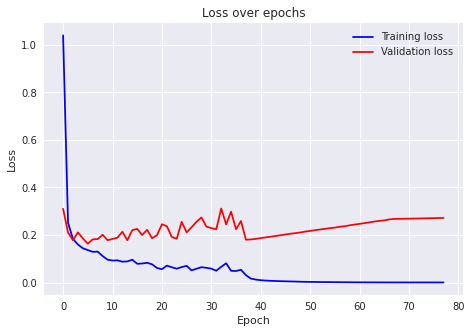

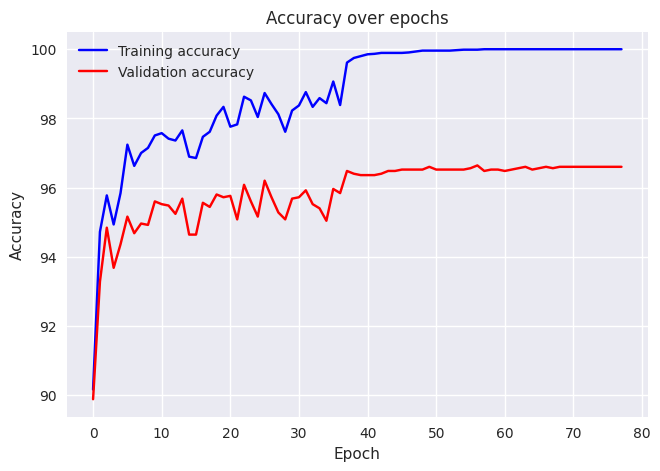

In [23]:
if torch.cuda.is_available():
    print("You're now training using GPU\n")
    model = model.float().to(torch.device('cuda'))
    DEVICE = 'cuda'
else:
    print("You're now training using CPU\n")
    model = model.float().to(torch.device('cpu'))
    DEVICE = 'cpu'

st = time.time()
#start training the model
model, opt, _ = training_loop(model, criterion, early_stopping , patience ,opt, X_train, y_train, X_val, y_val, EPOCHS, DEVICE, scheduler, scheduler_on = 'valid_acc')
et = time.time()

# get the execution time
elapsed_time = (et - st)/60 if et - st >= 60 else et - st
unit = 'minutes' if et - st >= 60 else 'seconds'

print(f'{DEVICE} execution time to train the network in {EPOCHS} epochs is: {elapsed_time:.2f} {unit}.')

### Test Model

In [24]:
test_loss, test_accuracy = model_evaluation(model, X_test, y_test, DEVICE)
print(f"The test loss: {test_loss} And the test accuracy: {test_accuracy}% for batch size 20.")

The test loss: 0.273 And the test accuracy: 99.15% for batch size 20.


### **Dynamic Quantize the Le-Net 5 model.**

Involves not just converting the weights to int8 (as in all quantization variants), but also converting the activations to int8 on the fly, just before doing the computation (hence “dynamic”).
The computations will be performed using efficient int8 matrix multiplication and convolution implementations, resulting in faster compute.
However, the activations are read and written to memory in floating point format.

**Important note**: PyTorch quantized model run only in CPU, pytorch doesn't support CUDA backend for the quantized models.

REF: https://github.com/taldatech/ee046211-deep-learning/blob/main/ee046211_tutorial_10_compression_pruning_amp.ipynb

First Trial:- Build **qint8** quantized le-net 5 model and test it.

In [25]:
qint8_quantized_model = torch.quantization.quantize_dynamic(model, {nn.Linear, nn.Conv2d, nn.ReLU, nn.AvgPool2d}, dtype=torch.qint8)
print(qint8_quantized_model)

LeNet(
  (CNN): Sequential(
    (0): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(28, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (FC): Sequential(
    (0): DynamicQuantizedLinear(in_features=400, out_features=120, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (1): ReLU()
    (2): DynamicQuantizedLinear(in_features=120, out_features=84, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (3): ReLU()
    (4): DynamicQuantizedLinear(in_features=84, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
)


In [26]:
def size_of_model(model):
    """
    get the size of the model in MB.
    """
    torch.save(model.state_dict(), "temp.p")
    return os.path.getsize("temp.p")/1e6
    

print(f"Model Size (MB) {size_of_model(model)}")
print(f"qint8 quantized Model Size (MB) {size_of_model(qint8_quantized_model)}")


Model Size (MB) 0.287239
qint8 quantized Model Size (MB) 0.112501


In [27]:
def time_model_evaluation(model, X_test, y_test, DEVICE):
    s = time.time()
    test_loss, test_accuracy = model_evaluation(model, X_test, y_test, DEVICE)
    elapsed = time.time() - s
    return round(elapsed, 2), test_loss, test_accuracy
elapsed,  test_loss, test_accuracy = time_model_evaluation(model, X_test, y_test, DEVICE)
qint8_quant_elapsed,  qint8_quant_test_loss, qint8_quant_test_accuracy = time_model_evaluation(qint8_quantized_model, X_test, y_test, DEVICE)

print(f"CPU elapsed time to test the model {elapsed} seconds, the loss is {test_loss} and the accuracy is {test_accuracy}%.")
print(f"CPU elapsed time to test the qint8 quantized model {qint8_quant_elapsed} seconds, the loss is {qint8_quant_test_loss} and the accuracy is {qint8_quant_test_accuracy}%.")

CPU elapsed time to test the model 2.91 seconds, the loss is 0.273 and the accuracy is 99.15%.
CPU elapsed time to test the qint8 quantized model 3.16 seconds, the loss is 0.273 and the accuracy is 99.16%.


From the above results, you can see that quantized Le-Net5 model took less much time to test on the data with the same accuracy and a littel higher loss than the original model, also its size is the half of the original model.

#### Try the same quantized model but with different bits for the weights.

Second Trial:- Build **quint8** quantized le-net 5 model and test it.


In [28]:
quint8_quantized_model = torch.quantization.quantize_dynamic(model, {nn.Conv2d, nn.ReLU, nn.AvgPool2d}, dtype=torch.quint8)
print(f"quint8 quantized Size (MB) {size_of_model(quint8_quantized_model)}")
quint8_quant_elapsed,  quint8_quant_test_loss, quint8_quant_test_accuracy = time_model_evaluation(quint8_quantized_model, X_test, y_test, DEVICE)
print(f"CPU elapsed time to test the quint8 quantized model {quint8_quant_elapsed} seconds, the loss is {quint8_quant_test_loss} and the accuracy is {quint8_quant_test_accuracy}%.")

quint8 quantized Size (MB) 0.287239
CPU elapsed time to test the quint8 quantized model 2.9 seconds, the loss is 0.273 and the accuracy is 99.15%.


Third Trial:- Build **quint4x2** quantized le-net 5 model and test it.

In [29]:
quint4x2_quantized_model = torch.quantization.quantize_dynamic(model, {nn.Conv2d, nn.ReLU, nn.AvgPool2d}, dtype=torch.quint4x2)
print(f"quint4x2 quantized Size (MB) {size_of_model(quint4x2_quantized_model)}")
quint4x2_quant_elapsed,  quint4x2_quant_test_loss, quint4x2_quant_test_accuracy = time_model_evaluation(quint4x2_quantized_model, X_test, y_test, DEVICE)
print(f"CPU elapsed time to test the quint8 quantized model {quint4x2_quant_elapsed} seconds, the loss is {quint4x2_quant_test_loss} and the accuracy is {quint4x2_quant_test_accuracy}%.")

quint4x2 quantized Size (MB) 0.287239
CPU elapsed time to test the quint8 quantized model 2.9 seconds, the loss is 0.273 and the accuracy is 99.15%.


Last Trial:- Build **float16** quantized le-net 5 model and test it.

In [30]:
float16_quantized_model = torch.quantization.quantize_dynamic(model, {nn.Linear, nn.Conv2d, nn.ReLU, nn.AvgPool2d}, dtype=torch.float16)
print(f"Quantized Size (MB) {size_of_model(float16_quantized_model)}")
float16_quant_elapsed,  float16_quant_test_loss, float16_quant_test_accuracy = time_model_evaluation(float16_quantized_model, X_test, y_test, DEVICE)
print(f"CPU elapsed time to test the float16 quantized model {float16_quant_elapsed} seconds, the loss is {float16_quant_test_loss} and the accuracy is {float16_quant_test_accuracy}%.")

Quantized Size (MB) 0.289205
CPU elapsed time to test the float16 quantized model 3.18 seconds, the loss is 0.273 and the accuracy is 99.15%.


#### The optimal fractional and int bits

Based on the previous trials where we quantiaed the model with different data types (qint8, quint8, quint4x2, float16).

The best model in case of the weights size was **qint8 quantized** model since it quantize all the weights in linear network to int8 and the weights size was the half of the original model.